In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import getpass
pd.options.mode.chained_assignment = None

In [3]:
# Ruta para pcs
user = getpass.getuser() # Capturo el usuario local / Ejemplo "Llan_", este es el nombre de mi usuario que inicie sesion en la pc

if   user== "USUARIO": # Layla @hugoferquiroz
     work = Path(r"D:\\Trabajo\Brecha-PRITE")
     data = Path(r"D:\\OneDrive\\Bases de datos\\Minedu compartido")
elif user== "hugo_": # Vicky @hugoferquiroz
     work = Path(r"D:\Brecha-PRITE")
     data = Path(r"C:\\Users\\hugo_\\OneDrive\Bases de datos\\Minedu compartido")

# Construcción de la base de datos

## Matricula

In [4]:
# Importamos las bases de datos
df_mat_20 = pd.read_excel(data/r'matricula prite\\AC - Reporte de matricula por edad en los PRITE 2020-2022 - SIAGIE.xlsx',sheet_name='2020',skiprows=3)
df_mat_21 = pd.read_excel(data/r'matricula prite\\AC - Reporte de matricula por edad en los PRITE 2020-2022 - SIAGIE.xlsx',sheet_name='2021',skiprows=3)
df_mat_22 = pd.read_excel(data/r'matricula prite\\AC - Reporte de matricula por edad en los PRITE 2020-2022 - SIAGIE.xlsx',sheet_name='2022',skiprows=3)

In [5]:
def clean_matricula(df, año):
    # Cambiar los nombres
    df.rename(columns={0:'Menor a 12 meses',
                        1:'Entre 12 meses a 1 año',
                        2:'Entre 1 año a 2 años',
                        3:'Entre 2 años a 3 años',
                        4:'Entre 3 años a 4 años',
                        5:'Entre 4 años a 5 años',
                        'TOTAL':'Matricula reportada'}, inplace=True) 
    # Eliminar columnas innecesarias    
    if 'ERROR EN REGISTRO' in  df.columns.to_list():
        df.drop(columns=['ERROR EN REGISTRO'], inplace=True)
    # Verificar la longitud del codigo modular
    df['COD_MOD'] = df['COD_MOD'].apply(lambda x: x.zfill(7))
    # Eliminar la ultima fila = fila del total
    df.drop(df[df['COD_MOD'].str.find('TOTAL')!=-1].index,inplace=True)
    # Completar los missing de la matricula con 0
    df.fillna(0, inplace=True)
    # Agregar el año de la base
    df['Año'] = año
    return df

In [6]:
# Limpio las bases
df_mat_2020 = clean_matricula(df_mat_20,2020)
df_mat_2021 = clean_matricula(df_mat_21,2021)
df_mat_2022 = clean_matricula(df_mat_22,2022)
# Verifico la cantidad de servicios
print('En el 2020 hay:', df_mat_2020.shape[0],'ssee')
print('En el 2021 hay:', df_mat_2021.shape[0],'ssee')
print('En el 2022 hay:', df_mat_2022.shape[0],'ssee')

En el 2020 hay: 103 ssee
En el 2021 hay: 108 ssee
En el 2022 hay: 116 ssee


In [7]:
# Consolido las bases
matricula = pd.concat([df_mat_2020,df_mat_2021])
matricula = pd.concat([matricula,df_mat_2022])

In [8]:
# Doy formato a las columnas
    ## Genero las columnas en el orden que quiero
columnas = matricula.columns.to_list()
columnas_matricula = [columnas[0]] + [columnas[-3]] + columnas[1:5] + columnas[-2:] + [columnas[-4]]
columnas_matricula
    ## Cambio el orden del DataFrame
matricula = matricula[columnas_matricula]
    ## Imputo 0 a los missing\
matricula.fillna(0,inplace=True)

In [9]:
matricula.sample(5)

,COD_MOD,Año,Menor a 12 meses,Entre 12 meses a 1 año,Entre 1 año a 2 años,Entre 2 años a 3 años,Entre 3 años a 4 años,Entre 4 años a 5 años,Matricula reportada
88,1753821,2020,2.0,11.0,5.0,0.0,0.0,0.0,18
27,1217728,2022,15.0,37.0,81.0,2.0,0.0,0.0,135
78,1731942,2020,6.0,1.0,7.0,0.0,0.0,0.0,14
43,1433267,2022,5.0,9.0,13.0,0.0,0.0,0.0,27
59,1599083,2022,8.0,17.0,15.0,1.0,0.0,0.0,41


Evolución de la matricula

In [10]:
matricula_año = matricula.groupby('Año', as_index=False)['Matricula reportada'].agg('sum')

In [11]:
matricula_año.to_excel(work/r'tablas\\Evolución de matricula.xlsx')

## Personal

NEXUS al 4 de setiembre del 2022

In [12]:
# Importo la base de datos
nexus = pd.read_stata(data/r'Nexus\\2022\\nexus_35sira.dta')

C:\Users\hugo_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\io\stata.py:1514: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


In [13]:
# Selecciono los ssee identificados como PRITE
ssee_prite = matricula[['COD_MOD']]
ssee_prite.drop_duplicates(inplace=True) 
personal = pd.merge(left= ssee_prite, right=nexus, left_on='COD_MOD', right_on='codmod', how='left', validate='1:m',indicator=True)

In [14]:
# Funcion para identificar los duplicados por orden de prioridad
def plaza_unica(dataframe,codigo_modular='codmod'):
    print('--------------------------------------------------------------')
    print('Transformación de variables')
    dataframe['codmod'] = dataframe['codmod'].apply(str)
    dataframe.rename(columns={'codmod':'cod_mod'},inplace=True)
    dataframe['cod_mod'] = dataframe['cod_mod'].apply(lambda x: x.zfill(7))
    print('1. Verificar cantidad de digitos código modular')
    
    dataframe = dataframe[(dataframe.sitlab != "B") & (dataframe.sitlab != "P")]
    print('2. Eliminar plazas bloqueadas y previstas')
    
    dataframe['prior_tipo'] = 1
    dataframe.loc[dataframe['tiporegistro']== 'EVENTUAL', 'prior_tipo'] = 2
    dataframe.loc[dataframe['tiporegistro']== 'PROYECTO', 'prior_tipo'] = 3
    dataframe.loc[dataframe['tiporegistro']== 'CUADRO DE HORAS', 'prior_tipo'] = 4
    dataframe.loc[dataframe['tiporegistro'].str.find('REEMPLAZO')!=-1, 'prior_tipo'] = 5
    print('3. Priorizacion del tipo de plaza')

    dataframe['prior_sitlab'] = 1
    dataframe.loc[(dataframe['sitlab']== 'F') | (dataframe['sitlab']== 'D') 
                 | (dataframe['sitlab']== 'E') | (dataframe['sitlab']== 'T'), 'prior_sitlab'] = 2
    dataframe.loc[(dataframe['sitlab']== 'C') | (dataframe['sitlab']== 'V'), 'prior_sitlab'] = 3
    print('4. Priorizacion de la situación laboral')

    dataframe['soplaza'] = 0
    dataframe.loc[((dataframe['estplaza'].str.find("SG")==-1) 
                  & (dataframe['estplaza'].str.find("CG")==-1) 
                  & (dataframe['estplaza'].str.find("ABAND")==-1)), 'soplaza'] = 1
    print('5. Identificación plaza con goce, sin goce')
    
    dataframe['sestpla'] = 0
    dataframe.loc[dataframe['estplaza']== 'ACTIV', 'sestpla'] = 1
    print('6. Identificación estado de la plaza')
    
    dataframe.loc[dataframe['jornlab']=='', 'jornlab'] = 99
    dataframe = dataframe.sort_values(by='jornlab', ascending=False)
    dataframe['sjornlb'] = dataframe['jornlab'].rank(method='dense', ascending=False)
    print('7. Ordenamiento descendente de la jornada laboral')

    print('--------------------------------------------------------------')
    dataframe = dataframe.sort_values(['descreg', 'nombreooii', 'cod_mod', 'codplaza', 'prior_tipo', 
                          'prior_sitlab', 'soplaza', 'sestpla', 'sjornlb'])
    dataframe['tipo_fin'] = dataframe.groupby(['cod_mod', 'codplaza']).cumcount()
    dataframe['tipo_fin'] = dataframe['tipo_fin'] + 1
    print('Identificación plaza única')
    print(dataframe.groupby(['tipo_fin'])['tipo_fin'].count())
    print('Plaza original tienen la etiqueta igual a 1')
    return dataframe


In [15]:
# Identifico los duplicados
personal = plaza_unica(personal)

--------------------------------------------------------------
Transformación de variables
1. Verificar cantidad de digitos código modular
2. Eliminar plazas bloqueadas y previstas
3. Priorizacion del tipo de plaza
4. Priorizacion de la situación laboral
5. Identificación plaza con goce, sin goce
6. Identificación estado de la plaza
7. Ordenamiento descendente de la jornada laboral
--------------------------------------------------------------
Identificación plaza única
tipo_fin
1    519
2     28
3      1
4      1
Name: tipo_fin, dtype: int64
Plaza original tienen la etiqueta igual a 1


In [16]:
# Elimino los duplicados
personal = personal.loc[(personal['tipo_fin']==1) | (personal['_merge']=='left_only')]

Personal por regimen laboral

In [17]:
pd.crosstab(personal['descargo'],personal['desley'],margins=True)

desley,D.L. 1153,D.L. 276,DL 1057,LEY 29944,LEY 30328,LEY 30493,All
descargo,,,,,,,
AUXILIAR DE EDUCACION,0,0,0,0,0,8,8
COORDINACION PEDAGOGICO,0,0,0,1,0,0,1
COORDINADOR ACADEMICO,0,0,0,5,0,0,5
DIRECTOR I.E.,0,0,0,33,0,0,33
DOCENTE COORDINADOR,0,0,0,0,1,0,1
FISIOTERAPEUTA,0,1,0,0,0,0,1
OFICINISTA,0,2,0,0,0,0,2
PROFESIONAL DE TERAPIA FÍSICA PARA LOS PROGRAMAS DE INTERVENCIÓN TEMPRANA,0,0,123,0,0,0,123
PROFESOR,0,0,0,121,146,0,267


In [18]:
# Exporto la tabla
(pd.crosstab(personal['descargo'],personal['desley'],margins=True)).to_excel(work/r'tablas\\personal por regimen laboral.xlsx')

Personal por tipo de trabajador

In [19]:
pd.crosstab(personal['descargo'],personal['desctipotrab'],margins=True)

desctipotrab,ADMINISTRATIVO,CAS,DOCENTE,PROFESIONAL DE LA SALUD,All
descargo,,,,,
AUXILIAR DE EDUCACION,0,0,8,0,8
COORDINACION PEDAGOGICO,0,0,1,0,1
COORDINADOR ACADEMICO,0,0,5,0,5
DIRECTOR I.E.,0,0,33,0,33
DOCENTE COORDINADOR,0,0,1,0,1
FISIOTERAPEUTA,1,0,0,0,1
OFICINISTA,2,0,0,0,2
PROFESIONAL DE TERAPIA FÍSICA PARA LOS PROGRAMAS DE INTERVENCIÓN TEMPRANA,0,123,0,0,123
PROFESOR,0,0,267,0,267


In [20]:
(pd.crosstab(personal['descargo'],personal['desctipotrab'],margins=True)).to_excel(work/r'tablas\\personal por tipo de trabajador.xlsx')

In [21]:
# Homogenizo los perfiles
    ## Docentes
personal['Profesor'] = 0
personal.loc[(personal['descargo']=='PROFESOR') | 
             (personal['descargo']=='PROFESOR (FUNCIONES DE DIRECTOR)') | 
             (personal['descargo']=='PROFESOR COORDINADOR') |
             (personal['descargo']=='COORDINACION PEDAGOGICO') |
             (personal['descargo']=='AUXILIAR DE EDUCACION') | 
             (personal['descargo']=='DOCENTE COORDINADOR') |        
             (personal['descargo']=='COORDINADOR ACADEMICO') ,'Profesor'] =1 
    ## Director
personal['Director'] = 0
personal.loc[(personal['descargo']=='DIRECTOR I.E.') ,'Director'] =1 
    ## Tecnologos medicos
personal['Tecnologo medico'] = 0
personal.loc[(personal['descargo']=='PROFESIONAL DE TERAPIA FÍSICA PARA LOS PROGRAMAS DE INTERVENCIÓN TEMPRANA') | 
             (personal['descargo']=='TERAPISTA') | 
             (personal['descargo']=='FISIOTERAPEUTA'),'Tecnologo medico'] =1     
    ## Psicologos
personal['Psicologo'] = 0
personal.loc[(personal['descargo'].str.find('PSICOLOGO')!=-1) ,'Psicologo'] =1 
    ## Personal administrativo
personal['Administrativos'] = 0
personal.loc[(personal['descargo']=='TRABAJADOR DE SERVICIO') | 
             (personal['descargo']=='TRABAJADOR DE SERVICIO II') | 
             (personal['descargo']=='TRABAJADOR DE SERVICIO III') | 
             (personal['descargo']=='OFICINISTA') |                              
             (personal['descargo']=='TECNICO ADMINISTRATIVO'),'Administrativos'] =1

In [22]:
# Colapso el DataFrame a nivel de servicio educativo
trabajadores = personal.groupby('COD_MOD', as_index=False).agg('sum')
# Doy formato a la base
columnas = trabajadores.columns.tolist()
columnas_nexus = [columnas[0]] + columnas[-5:]
trabajadores = trabajadores[columnas_nexus]
trabajadores.sample(5)

,COD_MOD,Profesor,Director,Tecnologo medico,Psicologo,Administrativos
20,1088566,6,0,1,0,1
93,1758861,1,1,1,0,0
34,1363126,2,1,1,0,0
64,1698687,1,0,1,0,0
106,1788660,3,0,1,0,0


## Datos del padron web
Padron web descargado de la [pagina web](http://escale.minedu.gob.pe/uee/-/document_library_display/GMv7/view/958881) de escale con fecha 17/09/2022 y complemetado con información de las asignaciones temporales y unidades ejecutoras de la Unidad de Presupuesto

In [23]:
# Importo el padron de la Unidad de Presupuesto 
df_padron = pd.read_stata(data/r'Padron GG1.dta')
df_padron = df_padron.loc[df_padron['niv_mod']=='E0']

C:\Users\hugo_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\io\stata.py:1514: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


In [24]:
# Identifico a los servicios PRITE
padron = pd.merge(left= ssee_prite, right=df_padron, left_on='COD_MOD', right_on='cod_mod', how='left', validate='1:m',indicator=True)
# Filtro las columnas relevantes
datos_padron = ['COD_MOD','cen_edu','d_gestion','d_ges_dep','ubigeo','d_dpto','d_prov', 'd_dist','d_region','codooii', 'd_dreugel','nlat_ie','nlong_ie',
                'vraem_upp_2022','tipie_upp_2022','bilin_upp_2022','rural_upp_2022','fron_upp_2022','region','pliego','codue', 'unidadejecutora', 'nombentidad']
padron_web = padron[datos_padron]

In [25]:
padron_web.sample(5)

,COD_MOD,cen_edu,d_gestion,d_ges_dep,ubigeo,d_dpto,d_prov,d_dist,d_region,codooii,...,vraem_upp_2022,tipie_upp_2022,bilin_upp_2022,rural_upp_2022,fron_upp_2022,region,pliego,codue,unidadejecutora,nombentidad
70,1728518,PRITE 01 ABANCAY,P£blica de gesti¢n directa,Sector Educaci¢n,030101,APURIMAC,ABANCAY,ABANCAY,DRE APURIMAC,030001,...,No Vraem,Completo,No bilingue,Urbano,No frontera,APURIMAC,442. GOBIERNO REGIONAL DEL DEPARTAMENTO DE APU...,442307,307. EDUCACION ABANCAY,GOB. REG. APURIMAC- EDUCACION ABANCAY
8,1001627,LA VICTORIA,P£blica de gesti¢n directa,Sector Educaci¢n,021801,ANCASH,SANTA,CHIMBOTE,DRE ANCASH,020018,...,No Vraem,Completo,No bilingue,Urbano,No frontera,ANCASH,441. GOBIERNO REGIONAL DEL DEPARTAMENTO DE ANCASH,441301,301. EDUCACION SANTA,REGION ANCASH-EDUCACION SANTA
112,1793652,PRITE DIVINO NI¥O,P£blica de gesti¢n directa,Sector Educaci¢n,040520,AREQUIPA,CAYLLOMA,MAJES,DRE AREQUIPA,040010,...,No Vraem,Completo,No bilingue,Urbano,No frontera,AREQUIPA,443. GOBIERNO REGIONAL DEL DEPARTAMENTO DE ARE...,443311,311. UGEL LA JOYA,REGION AREQUIPA - UGEL LA JOYA
59,1627397,PRITE FAUSTINO ZAPICO RAMOS,P£blica de gesti¢n directa,Sector Educaci¢n,160601,LORETO,UCAYALI,CONTAMANA,DRE LORETO,160007,...,No Vraem,Completo,No bilingue,Urbano,No frontera,LORETO,453. GOBIERNO REGIONAL DEL DEPARTAMENTO DE LORETO,453302,302. EDUCACION CONTAMANA,REGION LORETO-EDUCACION UCAYALI-CONTAMANA LORETO
92,1768217,PRITE 50163 VIRGEN DE FATIMA,P£blica de gesti¢n directa,Sector Educaci¢n,080408,CUSCO,CALCA,YANATILE,DRE CUSCO,080004,...,No Vraem,Completo,No bilingue,Urbano,No frontera,CUSCO,446. GOBIERNO REGIONAL DEL DEPARTAMENTO DE CUSCO,446311,311. UGEL DE CALCA,"GOB.REG,DPTO. CUSCO- UGEL CALCA"


# Calculo de la brecha

## Consolidación de la base

In [26]:
df = pd.merge(left=padron_web, right=df_mat_2022, on='COD_MOD')
df = pd.merge(left=df, right=trabajadores, on='COD_MOD')
df.sample(3)

,COD_MOD,cen_edu,d_gestion,d_ges_dep,ubigeo,d_dpto,d_prov,d_dist,d_region,codooii,...,Entre 1 año a 2 años,Entre 2 años a 3 años,Entre 3 años a 4 años,Matricula reportada,Año,Profesor,Director,Tecnologo medico,Psicologo,Administrativos
29,1231539,PRITE VIRGEN DE FATIMA,P£blica de gesti¢n directa,Sector Educaci¢n,200601,PIURA,SULLANA,SULLANA,DRE PIURA,200010,...,13,0.0,0.0,36,2022,2,0,1,0,0
54,1548098,PRITE SANTA MARIA,P£blica de gesti¢n directa,Sector Educaci¢n,190101,PASCO,PASCO,CHAUPIMARCA,DRE PASCO,190001,...,1,0.0,0.0,8,2022,1,0,1,0,0
87,1753821,PRITE HUACCANA,P£blica de gesti¢n directa,Sector Educaci¢n,030604,APURIMAC,CHINCHEROS,HUACCANA,DRE APURIMAC,030006,...,7,0.0,0.0,17,2022,1,0,1,0,0


## Calculo los ratios de asignación

De acuerdo al [RVM 188-2019](https://cdn.www.gob.pe/uploads/document/file/348345/RVM_N__188-2019-MINEDU.pdf) como mínimo se asigna 1 personal docente, psicólogo y técnologo médico por cada 12 alumnos menores de 3 años. 

Los niños y niñas de 3 años de edad con discapacidad severa o multidiscapacidad pueden permanecer en el PRITE hasta los 5 años de edad, solo si se encuentran en una zona rural y/o bilingue o si en su jurisdicción no se cuanta con un CEBE

In [43]:
df['Personal segun norma'] = df['Matricula reportada']/12 # Redondea hacia abajo
df['Personal segun norma'] = df['Personal segun norma'].astype(int)
df.loc[df['Matricula reportada']<12, 'Personal segun norma'] = 1 # Los que tienen < 12 tbn se le da personal completo

In [46]:
# Calculo los requerimientos y excedentes
ls_personal = ['Profesor','Tecnologo medico','Psicologo']

for prof in ls_personal:
    df[f'{prof} requerimiento'] = np.where(df[f'{prof}']<=df['Personal segun norma'],df['Personal segun norma']-df[f'{prof}'],0)
    df[f'{prof} excedente'] = np.where(df[f'{prof}']>=df['Personal segun norma'],df[f'{prof}']-df['Personal segun norma'],0)


df['Director norma'] = 1
df['Director requerimiento'] = np.where(df['Director']<=df['Director norma'],df['Director norma']-df['Director'],0)
df['Director excedente'] = np.where(df['Director']>=df['Director norma'],df['Director']-df['Director norma'],0)

In [47]:
# Verifico el personal que tiene < 12 alumnos
df.loc[df['Matricula reportada']<12, 'Profesor': ]

,Profesor,Director,Tecnologo medico,Psicologo,Administrativos,Personal segun norma,Profesor requerimiento,Profesor excedente,Tecnologo medico requerimiento,Tecnologo medico excedente,Psicologo requerimiento,Psicologo excedente,Director norma,Director requerimiento,Director excedente
36,1,0,1,0,0,1,0,0,0,0,1,0,1,1,0
54,1,0,1,0,0,1,0,0,0,0,1,0,1,1,0
69,1,0,1,0,0,1,0,0,0,0,1,0,1,1,0
74,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0
111,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0
112,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0
113,0,0,0,1,0,1,1,0,1,0,0,0,1,1,0
114,0,0,0,1,0,1,1,0,1,0,0,0,1,1,0
115,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0


## Estructura de costos

In [48]:
def table_costo(data_frame):
    # Calculo el costo
    w_psico, w_profe,w_tec_medico,w_director = 2500*12+600, 12*86.67*30*(1+0.096*0.65)+600, 2000*12+600, 12*86.67*40*(1+0.096*0.65)+600+600 
    data_frame['Costo-Profesor'] = data_frame['Brecha-Profesor']*w_profe
    data_frame['Costo-Director'] = data_frame['Brecha-Director']*w_director
    data_frame['Costo-Tecnologo medico'] = data_frame['Brecha-Tecnologo medico']*w_tec_medico
    data_frame['Costo-Psicologo'] = data_frame['Brecha-Psicologo']*w_profe

    # Doy formato a la tabla
    data_frame.loc['Total'] = data_frame.sum()
    data_frame_resumen = data_frame.style.format({'Costo-Profesor':'S/{:20,.0f}','Costo-Director':'S/{:20,.0f}','Costo-Tecnologo medico':'S/{:20,.0f}','Costo-Psicologo':'S/{:20,.0f}',
                                                  'Brecha-Profesor': '{:20,.0f}','Brecha-Director': '{:20,.0f}','Brecha-Tecnologo medico': '{:20,.0f}','Brecha-Psicologo': '{:20,.0f}'})
                                                                            
    return data_frame_resumen


## Brecha sin optimizar

En este escenario no se usan las plazas excedentes para cubrir los requerimientos identificados por lo que la brecha es equivalente a los requerimientos identificados 

In [52]:
# Colapso la brecha por region
sr = df.groupby(['region'])['Profesor requerimiento','Director requerimiento','Tecnologo medico requerimiento','Psicologo requerimiento'].sum()
sr.rename(columns={'Profesor requerimiento': 'Brecha-Profesor',
                   'Director requerimiento': 'Brecha-Director',
                   'Tecnologo medico requerimiento': 'Brecha-Tecnologo medico',
                   'Psicologo requerimiento': 'Brecha-Psicologo'},inplace=True)                           

C:\Users\hugo_\AppData\Local\Temp\ipykernel_14348\1724990708.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sr = df.groupby(['region'])['Profesor requerimiento','Director requerimiento','Tecnologo medico requerimiento','Psicologo requerimiento'].sum()


In [53]:
sr_region = table_costo(sr)
sr_region

,Brecha-Profesor,Brecha-Director,Brecha-Tecnologo medico,Brecha-Psicologo,Costo-Profesor,Costo-Director,Costo-Tecnologo medico,Costo-Psicologo
region,,,,,,,,
AMAZONAS,1,2,1,3,"S/ 33,748","S/ 90,795","S/ 24,600","S/ 101,244"
ANCASH,1,1,13,16,"S/ 33,748","S/ 45,398","S/ 319,800","S/ 539,970"
APURIMAC,4,7,1,9,"S/ 134,993","S/ 317,783","S/ 24,600","S/ 303,733"
AREQUIPA,2,3,8,13,"S/ 67,496","S/ 136,193","S/ 196,800","S/ 438,726"
AYACUCHO,0,1,4,5,S/ 0,"S/ 45,398","S/ 98,400","S/ 168,741"
CAJAMARCA,1,2,2,8,"S/ 33,748","S/ 90,795","S/ 49,200","S/ 269,985"
CALLAO,1,1,10,13,"S/ 33,748","S/ 45,398","S/ 246,000","S/ 438,726"
CUSCO,10,13,15,37,"S/ 337,482","S/ 590,168","S/ 369,000","S/ 1,248,682"
HUANCAVELICA,1,3,2,5,"S/ 33,748","S/ 136,193","S/ 49,200","S/ 168,741"


In [56]:
sr_region.to_excel(work/r'tablas\\brecha sin racio.xlsx')

## Brecha optimizada 

En este escenario se usan las plazas excedentes para cubrir los requerimientos identificados siempre y cuando estos excedentes sean reubicados dentro de la region

In [57]:
# Calculo la brecha/requerimientos
df_copy = df.copy()
ls_cargos = ['Profesor','Director',	'Tecnologo medico', 'Psicologo']
for prof in ls_cargos:
    df_copy[f'Brecha-{prof}'] = df_copy[f'{prof}']-df_copy['Personal segun norma']

In [58]:
# Colapso la brecha por region
cr = df_copy.groupby(['region'])['Brecha-Profesor','Brecha-Director','Brecha-Tecnologo medico','Brecha-Psicologo'].sum()

for prof in ls_cargos:
    cr.loc[cr[f'Brecha-{prof}']>=0 , [f'Brecha-{prof}']] = 0
    cr.loc[cr[f'Brecha-{prof}']<0,f'Brecha-{prof}']  = np.abs(cr[f'Brecha-{prof}'])


C:\Users\hugo_\AppData\Local\Temp\ipykernel_14348\2681851656.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cr = df_copy.groupby(['region'])['Brecha-Profesor','Brecha-Director','Brecha-Tecnologo medico','Brecha-Psicologo'].sum()


In [59]:
# Costo 
cr_region = table_costo(cr)
cr_region

,Brecha-Profesor,Brecha-Director,Brecha-Tecnologo medico,Brecha-Psicologo,Costo-Profesor,Costo-Director,Costo-Tecnologo medico,Costo-Psicologo
region,,,,,,,,
AMAZONAS,1,3,1,3,"S/ 33,748","S/ 136,193","S/ 24,600","S/ 101,244"
ANCASH,0,14,13,16,S/ 0,"S/ 635,566","S/ 319,800","S/ 539,970"
APURIMAC,4,8,1,9,"S/ 134,993","S/ 363,180","S/ 24,600","S/ 303,733"
AREQUIPA,0,10,8,13,S/ 0,"S/ 453,975","S/ 196,800","S/ 438,726"
AYACUCHO,0,5,4,5,S/ 0,"S/ 226,988","S/ 98,400","S/ 168,741"
CAJAMARCA,0,6,2,8,S/ 0,"S/ 272,385","S/ 49,200","S/ 269,985"
CALLAO,1,12,10,13,"S/ 33,748","S/ 544,770","S/ 246,000","S/ 438,726"
CUSCO,3,32,14,37,"S/ 101,244","S/ 1,452,721","S/ 344,400","S/ 1,248,682"
HUANCAVELICA,0,5,2,5,S/ 0,"S/ 226,988","S/ 49,200","S/ 168,741"


In [60]:
# Exporto los resultados
cr_region.to_excel(work/r'tablas\\brecha con racio.xlsx')

# Focalizacion y priorizacion de recursos

Identificamos los colegios que tienen necesidades conjuntas

<AxesSubplot:>

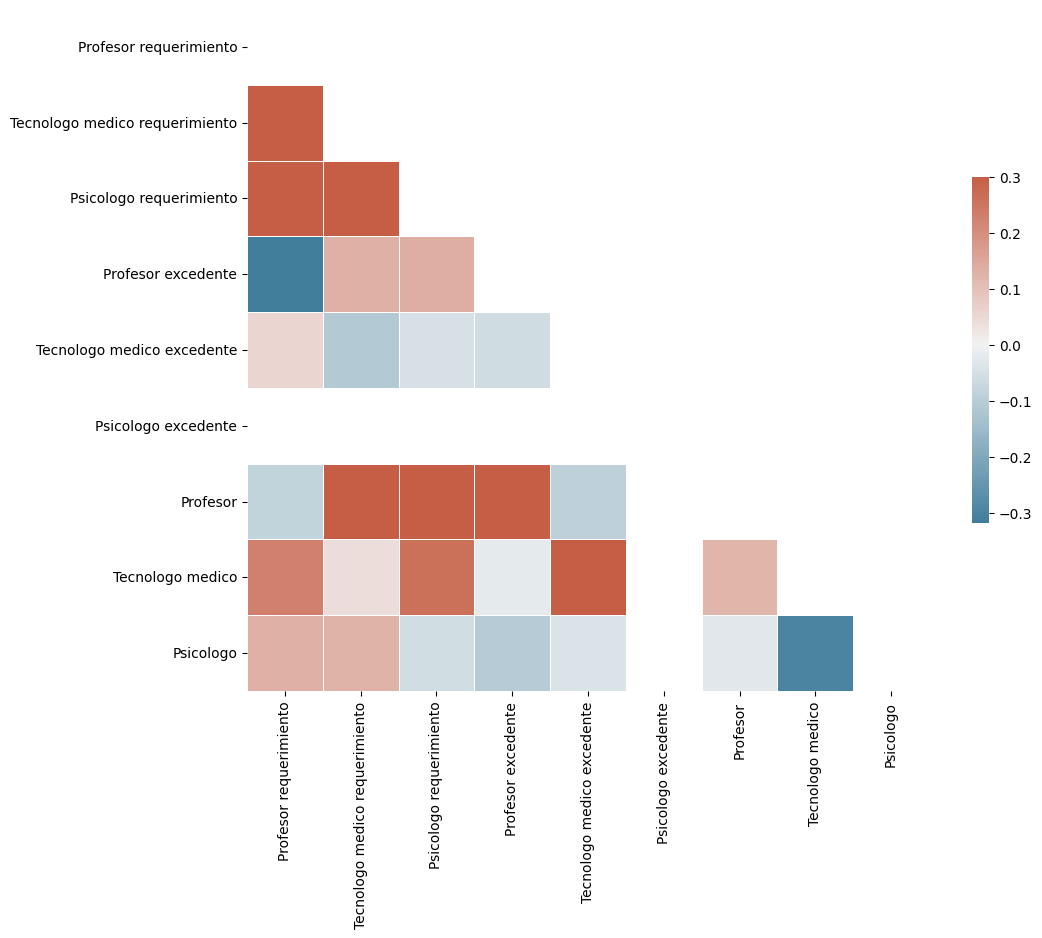

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['Profesor requerimiento','Tecnologo medico requerimiento','Psicologo requerimiento',
           'Profesor excedente','Tecnologo medico excedente','Psicologo excedente',
           'Profesor','Tecnologo medico','Psicologo']].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [62]:
# Filtramos a los colegios que tengan por lo menos un requerimiento
df_req = df.loc[(df['Profesor requerimiento']!=0) | (df['Tecnologo medico requerimiento']!=0) | (df['Psicologo requerimiento']!=0) ]
print('Por lo menos tienen un requerimiento:',df_req.shape[0],'colegios')

Por lo menos tienen un requerimiento: 116 colegios


In [63]:
# Filtramos a los colegios que no tengan el total de cantidad de personal
df_req['Total personal'] = df_req['Profesor'] + df_req['Tecnologo medico'] + df['Psicologo'] + df['Director']
df_req['Personal norma'] = 3*(df_req['Matricula reportada']/12).astype(int) 

df_priorizado = df_req[df_req['Personal norma'] > df_req['Total personal']]
print('Por lo menos tienen un requerimiento:',df_priorizado.shape[0],'colegios')

Por lo menos tienen un requerimiento: 97 colegios


In [64]:
# Caracterizacion
df_priorizado['rural_upp_2022'].value_counts()

Urbano     97
Rural 3     0
Rural 2     0
Rural 1     0
Name: rural_upp_2022, dtype: int64

In [65]:
df_priorizado['vraem_upp_2022'].value_counts()

No Vraem    97
Vraem        0
Name: vraem_upp_2022, dtype: int64

In [66]:
df_priorizado['region'].value_counts().sort_index()

AMAZONAS               1
ANCASH                 2
APURIMAC               8
AREQUIPA               3
AYACUCHO               1
CAJAMARCA              3
CALLAO                 2
CUSCO                 13
HUANCAVELICA           2
HUANUCO                3
ICA                    4
JUNIN                  9
LA LIBERTAD            2
LAMBAYEQUE             1
LIMA                   1
LIMA METROPOLITANA    17
LORETO                 5
MADRE DE DIOS          1
MOQUEGUA               1
PASCO                  2
PIURA                  4
PUNO                   3
SAN MARTIN             3
TUMBES                 4
UCAYALI                2
Name: region, dtype: int64

In [67]:
(df_priorizado['region'].value_counts().sort_index()).to_excel(work/r'tablas\\ssee focalizados por regjon.xlsx')

## Priorizacion de personal directivo

Se prioriza cubrir los requerimientos de director en los servicios PRITE que tengan el equipo interdisciplinario completo

In [68]:
df.loc[(df['Director requerimiento']!=0) & (df['Profesor']!=0) & (df['Tecnologo medico']!=0) & (df['Psicologo']!=0), ['Director requerimiento','Profesor','Tecnologo medico','Psicologo']]

,Director requerimiento,Profesor,Tecnologo medico,Psicologo
48,1,2,1,1
